<a id="top"></a>
# Custom Mosaics <img align="right" style="padding:10px" src="../images/odc_logo.png">

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible: Median (midpoint of spectral data) and Max-NDVI (maximum vegetation respons). These mosaics are quite common and will be of value to a large number of users. 

Users should review the "Cloud Statistics" notebook for more information about the temporal and spatial sample. An understanding of the underlying data is important for creating a valid mosaic for further analyses. In many cases, cloud contamination will create poor mosaics. With a careful review of the cloud coverage over a given region and time period, it is possible to improve the mosaics and avoid false outputs. 

What does this Notebook do?

* [Setup the Environment](#environment_setup)
* [Choose Platforms and Products](#platforms_products)
* [Load and Clean Data from the Data Cube](#load_data)
* [Create Mosaics and View the Results](#create_mosaic)
* [Create GeoTIFF Output Products](#output_products)

<i><p style="color:red"><b>Red Text:</b> Indicates code blocks where user inputs can be provided.</p></i>

<i><b>NOTE:</b> Digital Earth Africa has adapted this notebook to run on their platform. The code is <a href="https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/DCAL/DCAL_notebooks/DCAL_Custom_Mosaics.ipynb" target="_blank">available here</a>. Their implementation cleans up some of the rougher edges that remain in this notebook.</i>

<a id="environment_setup"></a>
## Environment Setup [&#9652;](#top)
* **Surpress Python Warnings:** These warnings include notes about deprecitation of Python modules, etc.
* **Import Standard Python Modules:** Import external and standard Python modules including `datacube` which is part of the ODC framework, as well as `xarray` which is a useful external module.
* **Import DCAL Utilities:** Import a set of utilities developed by the DCAL team to help automate some of the more routine tasks in the notebooks. These utilities are located in `/DCAL_utils`.
* **Initialize Data Cube and Data Cube API**

[Back to Top](#top)

In [1]:
# Supress Python Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Standard Python Modules
import datacube
import xarray as xr  
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Add utils to the sys.path so that data_cube_utilities can be found. (Local folder hack.)
import sys
sys.path.append('../DCAL_utils')

# Import Data Cube API.
import data_access_api as dc_api

# Import display map functions
from dc_display_map import display_map

# Import clean mask function.
from clean_mask import landsat_qa_clean_mask

# Import mosaic functions.
from dc_mosaic import create_median_mosaic, create_max_ndvi_mosaic

# Import RGB functions.
from dc_rgb import rgb

# Import import export functions.
from import_export import export_slice_to_geotiff

In [4]:
# Initialize Data Cube API (dc_api) and Data Cube (dc)
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')
dc = api.dc

<a id="platforms_products"></a>
## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>
* **Select Product:** Specify the product you desire to use. Note you can see the complete list of products in this Cube in the introductory notebook (<a href="../Open%20Data%20Cube%20Application%20Library%20Notebooks.ipynb#products" target="_blank">click here</a>).
* **View Dataset Spatial and Temporal Extents:** Queries the Cube and displays the min/max latitude and longitude, and the start and end date and time.
* **Select Spatial and Temporal Extents:** Select the area of interest (AOI) and time range based on extents available.

[Back to Top](#top)

In [5]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_ledaps_kenya"
# platform = "LANDSAT_7"

# product = "ls8_lasrc_kenya"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_ghana"
# platform = "LANDSAT_7"

product = "ls8_lasrc_ghana"
platform = "LANDSAT_8"

In [6]:
# Print extents of the Data Cube so we know what data is available
extents = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))

print(latitude_extents)
print(longitude_extents)
print(time_extents)

(3.7730589405966173, 11.318637832619382)
(-3.772789446011382, 1.8863273493593828)
(numpy.datetime64('2013-04-13T10:10:55.000000000'), numpy.datetime64('2020-01-27T10:09:38.000000000'))


<p style="color:red";><b>Select Spatial and Temporal Extents:</b> Select the area of interest (AOI) and time range based on extents available.</p>

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Mombasa, Kenya
# latitude = (-4.1, -3.9) 
# longitude = (39.5, 39.7) 

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Tano-Offin Forest - Ghana
# latitude = (6.5814, 6.8978 ) 
# longitude = (-2.2955, -1.9395) 

# Mining Region near Obuasi, Ghana
latitude = (6.0985, 6.2675)
longitude = (-2.050, -1.8629)

# Time Period
time_extents = ('2019-01-01', '2019-03-31')

In [8]:
# Render a map of the Area of Interest.
display_map(latitude,longitude)

<a id="load_data"></a>
## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>
* **Load Data:** Load data based on selections above.
* **Display Summary:** Display a summary of dataset.

[Back to Top](#top)

In [9]:
# Load Data into xarray Dataset.
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'])

In [10]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset
landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 628, longitude: 695, time: 5)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-06T10:21:44 ... 2019-03-27T10:21:26
  * latitude   (latitude) float64 6.268 6.267 6.267 6.267 ... 6.099 6.099 6.099
  * longitude  (longitude) float64 -2.05 -2.05 -2.049 ... -1.863 -1.863 -1.863
Data variables:
    red        (time, latitude, longitude) int16 684 594 682 ... 1120 505 306
    green      (time, latitude, longitude) int16 713 671 701 ... 1205 673 526
    blue       (time, latitude, longitude) int16 364 369 391 355 ... 786 304 166
    nir        (time, latitude, longitude) int16 2641 2778 2526 ... 3359 3338
    swir1      (time, latitude, longitude) int16 2029 1855 1988 ... 1863 1740
    swir2      (time, latitude, longitude) int16 1255 997 1154 ... 1449 957 852
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 322 322 322
Attributes:
    crs:      EPSG:4326

In [11]:
#Create cloud mask and cleaned dataset.
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

<a id="create_mosaic"></a>
## <span id="mosaics">Create Mosaics and View the Results [&#9652;](#top)</span>

> **Median Mosaic**  
>  Masks clouds from imagery and use the median-valued cloud-free pixels in the time series.
>  More specifically, each band (e.g. red) of each pixel is assigned its median across time.
>  So this mosaic method generates values that are not in the dataset.
>
> **Max NDVI Mosaic**  
>  Masks clouds from imagery and use the Max NDVI across time for cloud-free pixels in the time series. 
>  The maximum NDVI will represent the highest amount of green vegetation 

[Back to Top](#top)

In [12]:
# Create mosaics
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)
max_ndvi_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask.values)

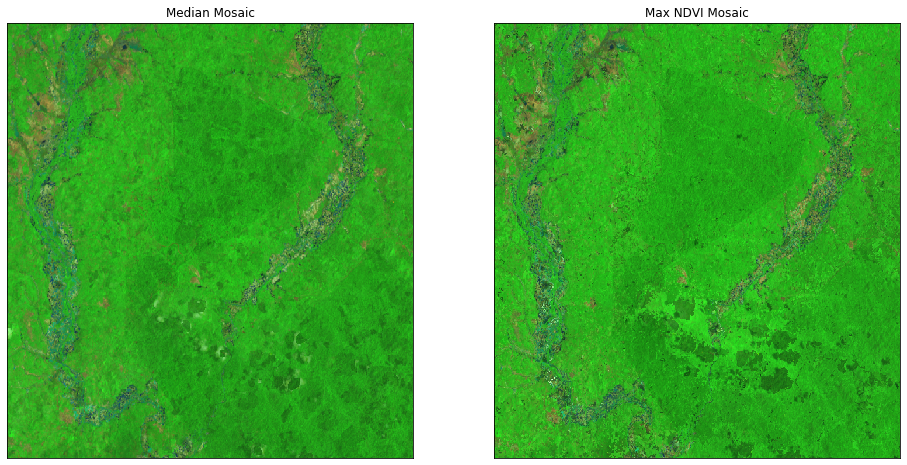

In [13]:
# Show two mosaics ... Median and Maximum NDVI

# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
median_rgb = median_composite[['swir2', 'nir', 'green']].to_array()
maxndvi_rgb = max_ndvi_composite[['swir2', 'nir', 'green']].to_array()
median_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=5000)
maxndvi_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('Median Mosaic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Max NDVI Mosaic'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()

<a id="output_products"></a>
## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>
<p style="color:red";><b>Set Export File Name:</b> Change the name of the output file, or it will be overwritten for each run. (Remove comment below marks to export.)</p>

[Back to Top](#top)

In [16]:
# Remove the comment tags (#) to export a GeoTIFF output product 
# export_slice_to_geotiff(median_composite, 'geotiffs/DEMO_median_composite.tif')
# export_slice_to_geotiff(max_ndvi_composite, 'geotiffs/DEMO_max_ndvi_composite.tif')

In [18]:
# Remove the comment tag (#) below to view the contents of the output folder
# !ls -lah geotiffs/